## Зависимостный парсинг (Dependency parsing)

Зависимостный парсинг - одна из немногих задач, где лингвистика и компьютерные науки продуктивно взаимодействуют. Основную теорию тут разрабатывают лингвисты, они же размечают корпусы, а модели построены на самых последних разробтах в области машинного обучения.

Лингвистическая часть это прежде всего Universal Dependcies - стандарт разметки отношений, объединяющий большое количество языков. 
    
На сайте Universal dependencies есть полное описание всех типов зависимостей, а также ссылки на доступные корпуса (там уже много языков):
http://universaldependencies.org/

Для русского стандартный корпус - Syntagrus:
https://github.com/UniversalDependencies/UD_Russian-SynTagRus

И не так давно выпустился корпус Taiga:
https://tatianashavrina.github.io/taiga_site/



Есть несколько хороших моделей, обученных на этих корпусах. **UDPipe** (от Карлова Университета в Чехии), **SyntaxNet** (Google), **MaltParser**, **TurkuNLP**, **Stanford NLP**. 

Лучшим выбором на данный момент является UDPipe - его просто установить и использовать, да и работает он неплохо. Подробнее про качество работы парсеров для русского языка вы можете узнать в этой статье - https://habr.com/ru/company/sberbank/blog/418701/ 

Попробуем UDPipe. Нужно установить пакет ufal.udpipe

In [ ]:
#pip install ufal.udpipe

А чтобы было удобнее, установим ещё spacy_udpipe. Это spacy-подобный интерфейс к udpipe.

In [ ]:
#pip install spacy-udpipe

In [1]:
import spacy_udpipe

In [2]:
# можно воспольоваться такой командой если вылезает PersmissionError
# !sudo chmod 777 /usr/local/lib/python3.6/site-packages/spacy_udpipe/models

Скачиваем модель для русского.

In [2]:
spacy_udpipe.download("ru")

Already downloaded a model for the 'ru' language


Загружаем.

In [3]:
nlp = spacy_udpipe.load("ru")

Попробуем разобрать какой-нибудь текст.

In [4]:
text = ("Более 150 лет назад Майкл Фарадей предположил, "
        "что скользкость льда связана с возникновением тонкого " 
        "слоя жидкой воды на его поверхности.")

# text = 'Я написал любое другое предложение.'
doc = nlp(text)
for token in doc:
    print(token.i+1, token.text, token.lemma_, 
          token.pos_, '_', token.tag_, token.head.i+1, token.dep_, '_', '_')

1 Более более ADV _ RBR 2 advmod _ _
2 150 150 NUM _ CD 3 nummod:gov _ _
3 лет год NOUN _ NN 7 obl _ _
4 назад назад ADV _ RB 7 advmod _ _
5 Майкл Майкл PROPN _ NNP 7 nsubj _ _
6 Фарадей Фарадей PROPN _ NNP 5 flat:name _ _
7 предположил предположить VERB _ VBC 7 ROOT _ _
8 , , PUNCT _ , 12 punct _ _
9 что что SCONJ _ IN 12 mark _ _
10 скользкость скользкость NOUN _ NN 12 nsubj:pass _ _
11 льда лед NOUN _ NN 10 nmod _ _
12 связана связать VERB _ VBNH 7 ccomp _ _
13 с с ADP _ IN 14 case _ _
14 возникновением возникновение NOUN _ NN 12 obl _ _
15 тонкого тонкий ADJ _ JJL 16 amod _ _
16 слоя слой NOUN _ NN 14 nmod _ _
17 жидкой жидкий ADJ _ JJL 18 amod _ _
18 воды вода NOUN _ NN 16 nmod _ _
19 на на ADP _ IN 21 case _ _
20 его его DET _ PRP$ 21 det _ _
21 поверхности поверхность NOUN _ NN 12 obl _ _
22 . . PUNCT _ . 7 punct _ _


Формат, в которым мы напечатали текст, называется Conll (по названию конференции Conference on Computational Natural Language Learning, в рамках который проводились и проводятся соревнования по парсингу). 

In [5]:
tree = []

for token in doc:
    if token.dep_ == 'ROOT':
        tree.append('\t'.join([str(token.i+1), token.text, token.lemma_, 
          token.pos_, '_', token.tag_, str(0), token.dep_, '_', '_']))
    else:
        tree.append('\t'.join([str(token.i+1), token.text, token.lemma_, 
          token.pos_, '_', token.tag_, str(token.head.i+1), token.dep_, '_', '_']))

Для работы с таким форматов в nltk есть специальный класс - DependencyGraph. Давайте посмотрим, как он работает.

In [6]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph
from collections import Counter
import numpy as np
import re
import warnings
import os
warnings.filterwarnings('ignore')

Обрабатываем наше предложение через него.

In [7]:
d = DependencyGraph('\n'.join(tree))

Теперь элементы хранятся в словаре (ключи - индексы слов)

In [8]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'ROOT': [7]}),
              'rel': None},
             1: {'address': 1,
              'word': 'Более',
              'lemma': 'более',
              'ctag': 'ADV',
              'tag': '_',
              'feats': 'RBR',
              'head': 2,
              'deps': defaultdict(list, {}),
              'rel': 'advmod'},
             2: {'address': 2,
              'word': '150',
              'lemma': '150',
              'ctag': 'NUM',
              'tag': '_',
              'feats': 'CD',
              'head': 3,
              'deps': defaultdict(list, {'advmod': [1]}),
              'rel': 'nummod:gov'},
             3: {'address': 3,
             

Есть ещё удобный метод .triples() который возращается все тройки СЛОВО_1 - зависимость - СЛОВО_2

In [9]:
d.root = d.nodes[0] # чтобы метод сработал нужно установить корневой элемент
list(d.triples())

[((None, 'TOP'), 'ROOT', ('предположил', 'VERB')),
 (('предположил', 'VERB'), 'obl', ('лет', 'NOUN')),
 (('лет', 'NOUN'), 'nummod:gov', ('150', 'NUM')),
 (('150', 'NUM'), 'advmod', ('Более', 'ADV')),
 (('предположил', 'VERB'), 'advmod', ('назад', 'ADV')),
 (('предположил', 'VERB'), 'nsubj', ('Майкл', 'PROPN')),
 (('Майкл', 'PROPN'), 'flat:name', ('Фарадей', 'PROPN')),
 (('предположил', 'VERB'), 'ccomp', ('связана', 'VERB')),
 (('связана', 'VERB'), 'punct', (',', 'PUNCT')),
 (('связана', 'VERB'), 'mark', ('что', 'SCONJ')),
 (('связана', 'VERB'), 'nsubj:pass', ('скользкость', 'NOUN')),
 (('скользкость', 'NOUN'), 'nmod', ('льда', 'NOUN')),
 (('связана', 'VERB'), 'obl', ('возникновением', 'NOUN')),
 (('возникновением', 'NOUN'), 'case', ('с', 'ADP')),
 (('возникновением', 'NOUN'), 'nmod', ('слоя', 'NOUN')),
 (('слоя', 'NOUN'), 'amod', ('тонкого', 'ADJ')),
 (('слоя', 'NOUN'), 'nmod', ('воды', 'NOUN')),
 (('воды', 'NOUN'), 'amod', ('жидкой', 'ADJ')),
 (('связана', 'VERB'), 'obl', ('поверхност

## Для чего можно использовать зависимости?

Попробуем проанализировать тексты с помощью зависимостей. Сами парсить не будет, а возьмем уже готовые разборы из Тайги.

Я взял маленький кусочек (Arzamas) - скачать его можно тут - https://linghub.ru/static/Taiga/Arzamas.zip

В нем есть папка с обработанными текстами. Соберем их в один список.

In [11]:
path = 'Arzamas/texts_tagged/'
files = [path+file for file in os.listdir(path)]

Посмотрим, что лежит в этих файлах.

In [12]:
file = open(files[0]).read()

Разобранные предложения в том же формате CONLL

In [13]:
tree = [x for x in file.split('\n\n')[0].split('\n')]

Перед разбором ещё может быть указана метаинформация (начало дока, параграфа, номер предложения, само предложения в изначальном виде).

In [14]:
tree

['# text = # newpar',
 '# sent_id = 1915',
 '# text = "Я люблю богемных писателей: Фицджеральд, этот парень, который покончил жизнь самоубийством...',
 '1\t"\t"\tPUNCT\t_\t_\t2\tpunct\t_\tSpaceAfter=No',
 '2\tЯ\tя\tPRON\t_\tCase=Nom|Number=Sing|Person=1\t3\tnsubj\t_\t_',
 '3\tлюблю\tлюбить\tVERB\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_',
 '4\tбогемных\tбогемный\tADJ\t_\tAnimacy=Anim|Case=Acc|Degree=Pos|Number=Plur\t5\tamod\t_\t_',
 '5\tписателей\tписатель\tNOUN\t_\tAnimacy=Anim|Case=Acc|Gender=Masc|Number=Plur\t3\tobj\t_\tSpaceAfter=No',
 '6\t:\t:\tPUNCT\t_\t_\t5\tpunct\t_\t_',
 '7\tФицджеральд\tФицджеральд\tPROPN\t_\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t5\tnsubj\t_\tSpaceAfter=No',
 '8\t,\t,\tPUNCT\t_\t_\t7\tpunct\t_\t_',
 '9\tэтот\tэтот\tDET\t_\tCase=Nom|Gender=Masc|Number=Sing\t10\tamod\t_\t_',
 '10\tпарень\tпарень\tNOUN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t3\tappos\t_\tSpaceAfter=No',
 '11\t,\t,\tPUNCT\t_\

Но нам она не нужна. Соберем в один список все деревья.

In [15]:
trees = []

for file in files:
    parsed_sents = open(file).read().split('\n\n')
    
    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))
        

In [16]:
trees[0]

'1\t"\t"\tPUNCT\t_\t_\t2\tpunct\t_\tSpaceAfter=No\n2\tЯ\tя\tPRON\t_\tCase=Nom|Number=Sing|Person=1\t3\tnsubj\t_\t_\n3\tлюблю\tлюбить\tVERB\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n4\tбогемных\tбогемный\tADJ\t_\tAnimacy=Anim|Case=Acc|Degree=Pos|Number=Plur\t5\tamod\t_\t_\n5\tписателей\tписатель\tNOUN\t_\tAnimacy=Anim|Case=Acc|Gender=Masc|Number=Plur\t3\tobj\t_\tSpaceAfter=No\n6\t:\t:\tPUNCT\t_\t_\t5\tpunct\t_\t_\n7\tФицджеральд\tФицджеральд\tPROPN\t_\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t5\tnsubj\t_\tSpaceAfter=No\n8\t,\t,\tPUNCT\t_\t_\t7\tpunct\t_\t_\n9\tэтот\tэтот\tDET\t_\tCase=Nom|Gender=Masc|Number=Sing\t10\tamod\t_\t_\n10\tпарень\tпарень\tNOUN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t3\tappos\t_\tSpaceAfter=No\n11\t,\t,\tPUNCT\t_\t_\t10\tpunct\t_\t_\n12\tкоторый\tкоторый\tPRON\t_\tCase=Nom\t13\tnsubj\t_\t_\n13\tпокончил\tпокончить\tVERB\t_\tAspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|

In [17]:
[x.replace('\t', ' ') for x in trees[2].split('\n')]

['1 Некоторые некоторый DET _ Case=Nom|Number=Plur 3 nsubj _ _',
 '2 были быть VERB _ Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act 3 cop _ _',
 '3 алкоголиками алкоголик NOUN _ Animacy=Inan|Case=Ins|Gender=Masc|Number=Plur 0 root _ _',
 '4 и и CCONJ _ _ 5 cc _ _',
 '5 наркоманами наркоман NOUN _ Animacy=Inan|Case=Ins|Gender=Masc|Number=Plur 3 conj _ SpaceAfter=No',
 '6 , , PUNCT _ _ 5 punct _ _',
 '7 но но CCONJ _ _ 9 cc _ _',
 '8 классно классно ADV _ Degree=Pos 9 advmod _ _',
 '9 проводили проводить VERB _ Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act 3 conj _ _',
 '10 время время NOUN _ Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing 9 obj _ SpaceAfter=No',
 '11 . . PUNCT _ _ 10 punct _ _']

In [18]:
d = DependencyGraph(trees[10])

In [19]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'root': [6], 'ROOT': []}),
              'rel': None},
             1: {'address': 1,
              'word': 'Я',
              'lemma': 'я',
              'ctag': 'PRON',
              'tag': '_',
              'feats': 'Case=Nom|Number=Sing|Person=1',
              'head': 6,
              'deps': defaultdict(list, {}),
              'rel': 'nsubj'},
             6: {'address': 6,
              'word': 'покупаю',
              'lemma': 'покупать',
              'ctag': 'VERB',
              'tag': '_',
              'feats': 'Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act',
              'head': 0,
              'deps': defa

In [20]:
d.root = d.nodes[0] # чтобы метод сработал нужно установить корневой элемент
list(d.triples())

[((None, 'TOP'), 'root', ('покупаю', 'VERB')),
 (('покупаю', 'VERB'), 'nsubj', ('Я', 'PRON')),
 (('покупаю', 'VERB'), 'nsubj', ('книги', 'NOUN')),
 (('покупаю', 'VERB'), 'obl', ('красоты', 'NOUN')),
 (('красоты', 'NOUN'), 'advmod', ('не', 'PART')),
 (('красоты', 'NOUN'), 'case', ('для', 'ADP')),
 (('покупаю', 'VERB'), 'punct', ('.', 'PUNCT'))]

Что с этим можно сделать?

Например, можно пройтись по корпусу и достать все зависимые какого-то слова.

In [21]:
modifiers = Counter()
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    for e1, rel, e2 in triples:
        if e1[0] == 'писатель' and rel == 'amod':
            modifiers[e2[0]] += 1
    # ваш код здесь
    

In [22]:
modifiers

Counter({'изощренный': 1,
         'наш': 1,
         'любимый': 1,
         'русский': 1,
         'московский': 2,
         'грузинский': 2,
         'великий': 2,
         'Сам': 1,
         'умеющий': 1,
         'известный': 1,
         'оказавшийся': 1,
         'церковный': 1,
         'древнегреческий': 1,
         'Замечательный': 1,
         'разоблаченный': 1,
         'Британский': 1})

In [23]:
modifiers = Counter()
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    for e1, rel, e2 in triples:
        if e1[0] == "мужчина" and rel == 'amod':
            modifiers[e2[0]] += 1
    # ваш код здесь
    

In [24]:
modifiers

Counter({'сильный': 1,
         'молодой': 1,
         'одетый': 1,
         '33-летний': 1,
         'Человеке-гризли': 1,
         'благообразный': 1})

Одно слова может быть недостаточно. Отношение часто указывает на главное слово в какой-то именной группе, а от него отходят отношения к другим её составляющим. Мы можем захотеть пройтись по всем ответвлениям, чтобы собрать всю именную группу. 

Удобнее всего это сделать через рекурсию. Напишем функцию, котороя проходит по всем зависимым конкретного узла в дереве и достает их зависимые, пока не упрется в терминальный узел.

Чтобы лучше понять, как работает рекурсия возьмем простую задачу - превратить список в вложенными списками в один список.

In [24]:
a = [1, 2, [3, 4], [[5], [6, 7]]]

In [72]:
# должно получиться [1, 2, 3, 4, 5, 6, 7]

In [23]:
def flatten_list(l):
    result = []
    
    for el in l:
        # окончание рекурсии - если текущий элемент не список
        if not isinstance(el, list):
            result.append(el)
        #если текущий элемент список, то применяем к нему flatten_list 
        else:
            result += flatten_list(el)
    
    return result

In [25]:
flatten_list(a)

[1, 2, 3, 4, 5, 6, 7]

Подробнее про рекурсию тут - https://foxford.ru/wiki/informatika/rekursiya-v-python

Теперь вы лучше будете понимать, что происходит в этой функции.

In [32]:
def get_subtree(nodes, node):
    
    
    if not nodes[node]['deps']:
        return [node]
    
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps'] 
                         if rel != 'punct'  # пунктуацию доставать не будем
                         for dep in nodes[node]['deps'][rel]]



Дерево можно нарисовать через networkx, чтобы лучше понимать какие поддеревья мы хотим достать.

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 

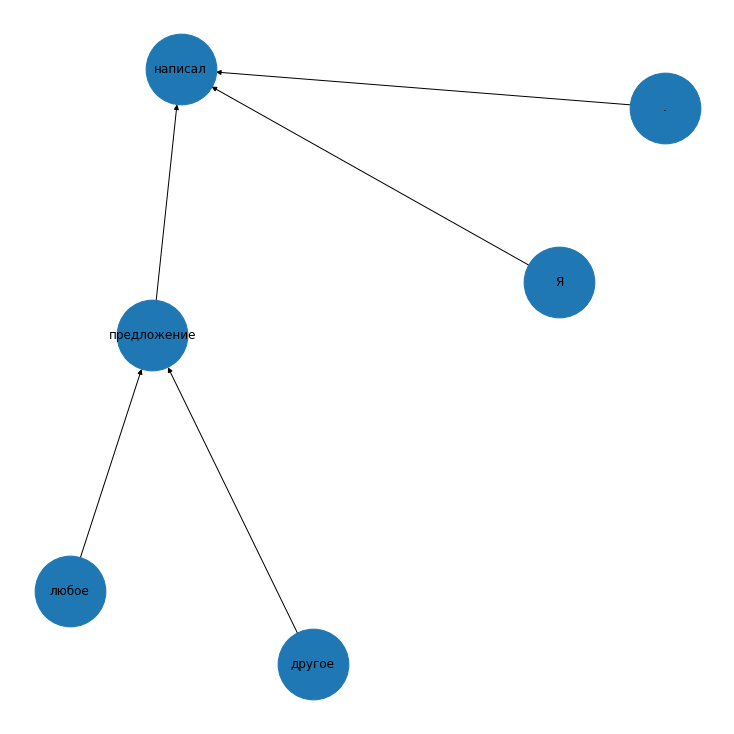

In [29]:
plt.figure(figsize=(10,10))
nx.draw(d.nx_graph(), labels=d.nx_labels, node_size=5000)

In [33]:
d.nx_labels

{1: 'Я', 2: 'написал', 3: 'любое', 4: 'другое', 5: 'предложение', 6: '.'}

Достанем все поддерево какого-нибудь элемента.

In [38]:
get_subtree(d.nodes, 5)

[5, [3], [4]]

Получается список с вложенными списками. Чтобы представить это все в читаемом формате лучше его раплющить ещё одной рекурсивной функцией (такой как мы написали выше). 

In [39]:
def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

In [40]:
flatten(get_subtree(d.nodes, 5))

[5, 3, 4]

Проверим, что досталось.

In [41]:
[d.nodes[i]['word'] for i in flatten(get_subtree(d.nodes, 5))]

['предложение', 'любое', 'другое']

Нужно ещё восстановить порядок.

In [42]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 5)))]

['любое', 'другое', 'предложение']

In [43]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 5)))]

['любое', 'другое', 'предложение']

Попробуем теперь также пройтись по корпусу, найти глаголы и если у этих глаголов есть **nsubj** и **obj** (или **obl**), то достать всё поддерево для них. Возможно таким способом получится доставь главную информацию из каждого предложения и получить саммари текста.

Возьмем ещё сырые тексты.

In [89]:
path_raw = 'Arzamas/texts/'
files_raw = [path_raw+file for file in os.listdir(path_raw)]

In [90]:
text_trees = []

for i, file in enumerate(files):
    parsed_sents = open(file).read().split('\n\n')
    raw = open(files_raw[i]).read()
    text = []
    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        text.append('\n'.join(tree))
    text_trees.append((raw, text))

In [98]:
summaries = []

for raw_text, trees in text_trees:
    sov_text = []
    
    for tree in trees:
        d = DependencyGraph(tree)
        
        for node_i, node in d.nodes.items():
            if node['ctag'] == 'VERB' and 'nsubj' in node['deps'] and ('obj' in node['deps']
                                                                       or 'obl' in node['deps']):

                subject = [d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 
                                                                              node['deps']['nsubj'][0])))]
                verb = node['word']

                obj = [d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 
                                                                              node['deps'].get('obj',
                                                                              node['deps'].get('obl'))[0])))]

                sov_text.append((' '.join(subject), verb, ' '.join(obj)))
                
    summaries.append((raw_text, sov_text))
    

In [102]:
summaries[3]

('В конце марта 1938 года в американском посольстве в Москве снова устраивали прием. Посол Джозеф Дэвис получил новое назначение и собрал московский высший свет, чтобы попрощаться. На прием был приглашен и Александр Афиногенов. Он танцевал с женой посла, и она светски жаловалась ему: "Вы  --  исключительная страна, единственная в мире. Что такое какая-нибудь Бельгия после вас!"\nНа приеме Афиногенова окружали новые лица: за прошедший год состав участников вечеров в посольстве кардинально изменился. Из знакомых остался только литовский поэт и дипломат Юргис Балтрушайтис: остальные не пережили 1937-й. Сенсацией вечера был председатель Военной коллегии Верховного суда СССР Василий Ульрих, выносивший приговоры на всех главных показательных процессах конца 1930-х годов. За две недели до приема в посольстве он приговорил к расстрелу участников вымышленного "правотроцкистского блока", среди которых были Генрих Ягода и Николай Бухарин. Весь вечер Ульриха окружали иностранные журналисты. Кто-то

Хороших саммари конечно не получилось. Чтобы довести это до ума нужно будет поправить много вещей: порядок субъекта и дополнения, отрицание, однородные дополнения, сложные предложения, анафору. 

Извлечение таких троек даже оформилось в отдельную задачу Open Information Extraction. Подробнее про неё можно почитать тут -   
1) оригинальная работа http://www.aaai.org/Papers/IJCAI/2007/IJCAI07-429.pdf  
2) одна из самых известных работ http://ml.cs.washington.edu/www/media/papers/reverb_emnlp2011.pdf  
3) одна из последних статей http://www.cse.iitd.ac.in/~mausam/papers/coling18.pdf  

Реализация OpenIE есть StandfordNLP и вот тут - https://github.com/dair-iitd/OpenIE-standalone

### Использование для других задач

Ещё зависимости можно использовать в качестве признаков для классификации или кластеризации.

Допустим мы хотим научиться выделять отношения между существительными. Мы можем пройтись по корпусу, достать все фразы, а потом достать из графа самый короткий путь, соединящию эти фразы.

Дальше путь можно каким-то образом преобразовать в векторы и напрмую засовывать в классификатор или кластеризатор. 

In [30]:
# поиск самого короткого пути есть в networkx
import networkx as nx

In [123]:
trees = []

for file in files:
    parsed_sents = open(file).read().split('\n\n')
    
    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))
        

In [142]:

dg = DependencyGraph(trees[100])
edges = []

for e in dg.nodes:
    for dep in dg.nodes[e]['deps']:
        for t in dg.nodes[e]['deps'][dep]:
            edges.append((e, t))




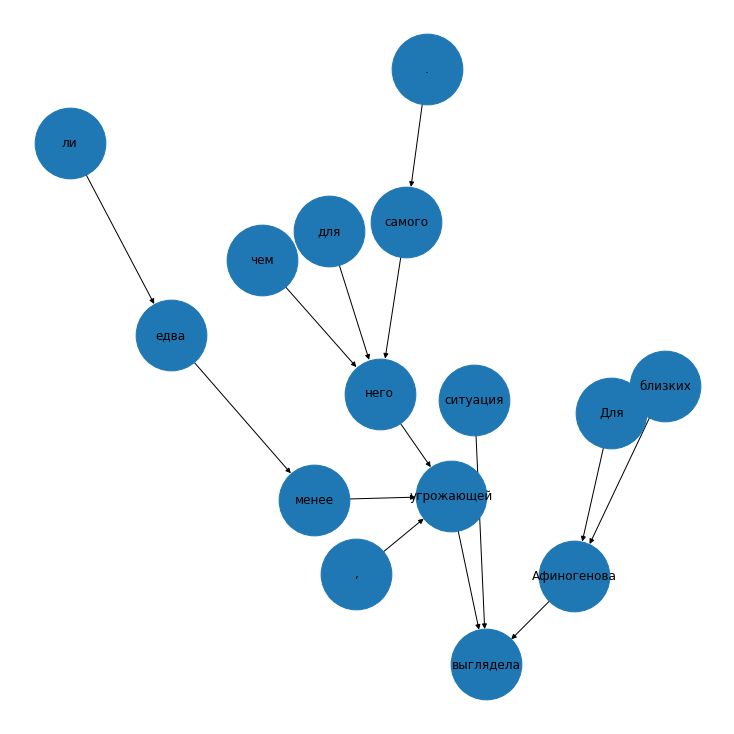

In [143]:
plt.figure(figsize=(10,10))
nx.draw(dg.nx_graph(), labels=dg.nx_labels, node_size=5000)

In [144]:
dg.nx_labels

{1: 'Для',
 2: 'близких',
 3: 'Афиногенова',
 4: 'ситуация',
 5: 'выглядела',
 6: 'едва',
 7: 'ли',
 8: 'менее',
 9: 'угрожающей',
 10: ',',
 11: 'чем',
 12: 'для',
 13: 'него',
 14: 'самого',
 15: '.'}

In [116]:
graph = nx.Graph()
graph.add_edges_from(edges)

In [148]:
nx.shortest_path(graph, 4, 9)

[4, 5, 6, 8, 9]

In [149]:
[dg.nx_labels[i] for i in nx.shortest_path(graph, 4, 9)]

['ситуация', 'выглядела', 'едва', 'менее', 'угрожающей']